In [1]:
EMULATORS_PATH = "/Users/gabe/projects/emulators/src"
RECOMBINATION_PATH = "/Users/gabe/projects/recombination/src" 

import sys
import os
import numpy as np
from scipy.interpolate import CubicSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

if EMULATORS_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/emulators/src")
if RECOMBINATION_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/recombination/src")
from TrainedEmulator import *
from ChainTools import *

from getdist import plots, MCSamples, loadMCSamples

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True

default_settings = plots.GetDistPlotSettings()
default_settings.axes_labelsize = 12
default_settings.fig_width_inch = 6
default_settings.linewidth = 2
default_settings.title_limit = 0
default_settings.legend_fontsize = 12

######################################################
#  Loading Chains
######################################################

chains_to_load = ["modrec_new", "modrec_new_lensing", "modrec_new_lensing_bao", "modrec_new_lensing_bao_shoes"]

chains = {}

chain_dirname = "/Users/gabe/projects/recombination/data/chains/"

for chain in chains_to_load:
    dirname = os.path.join(chain_dirname, "{}/chains".format(chain))
    s = loadMCSamples(os.path.join(dirname, chain))
    chains[chain] = s


s_planck = loadMCSamples(os.path.join(chain_dirname, "planck_baseline/base_plikHM_TTTEEE_lowl_lowE_lensing"))

planck_renames = {'omegabh2': 'omega_b',
                  'omegach2': 'omega_cdm', 
                  'tau': 'tau_reio', 
                  'ns': 'n_s'}
s_planck.updateRenames(planck_renames)
chains["planck_baseline"] = s_planck
planck_bestfit = chains["planck_baseline"].getParamBestFitDict()

s_class = loadMCSamples(os.path.join(chain_dirname, "modrec_new_lensing_bao_shoes_class/chains/modrec_new_lensing_bao_shoes.post.CLASS"))
chains["modrec_new_lensing_bao_shoes_class"] = s_class

######################################################
#  Loading Emulator
######################################################

emulator_dir = "/Users/gabe/projects/emulators/models"
emulator_name = "modrec_new_18"

em = TrainedEmulator(os.path.join(emulator_dir, emulator_name))

2023-10-31 16:37:32.028259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 16:37:35.002763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
import scipy.special
from scipy.optimize import fsolve

def get_physical_qi(standard_predictions, input_models, q_index):
    pivots=[933.3333,1066.6667,1200.0000,1333.3333,1466.6667]
    qlist=["q_1", "q_2", "q_3", "q_4", "q_5"]
    outlist = []
    for i in np.arange(len(input_models["H0"])):
        qi = input_models[qlist[q_index]][i]
        YHe = standard_predictions["YHe"][i]
        xe_max = 1 + YHe/2*(1-YHe)
        xe_fid = CubicSpline(em.output_info["output_z_grids"]["x_e"], standard_predictions["x_e"][i])(pivots[q_index])
        #p = fsolve(lambda aa: scipy.special.expit(aa)*xe_max - xe_fid, 0)
        p = scipy.special.logit(xe_fid/xe_max)
        outlist.append(scipy.special.expit(qi+p)*xe_max - xe_fid)
        
    return np.array(outlist)

chain_name = "modrec_new_lensing_bao_shoes"
total_predictions, total_models = get_predictions_for_selection(chains[chain_name], em, criteria='none')

standard_rec_models = total_models.copy()
extension_params = ["q_1", "q_2", "q_3", "q_4", "q_5"]
#extension_params = ["q_1"]
qtlist = ["qt_1", "qt_2", "qt_3", "qt_4", "qt_5"]
#pivots=[800.0000,933.3333,1066.6667,1200.0000,1333.3333,1466.6667,1600.0000]

for q in extension_params:
    standard_rec_models[q] = np.zeros(standard_rec_models["H0"].shape)

standard_rec_predictions = em.get_predictions_dict(standard_rec_models)

In [15]:
chain_name = "modrec_new_lensing_bao_shoes"
#name = "rs_star"
#label = "r_s^{\star}"
name = "qt_5"
label = "\\tilde{q}_5"
#chains[chain_name].addDerived(get_emulator_quantity_from_chain(em, chains[chain_name], name), name=name, label=label)
chains[chain_name].addDerived(get_physical_qi(standard_rec_predictions, total_models, 4), name=name, label=label)

In [16]:
chains[chain_name].saveChainsAsText(os.path.join("/Users/gabe/projects/recombination/data/chains/{}/chains/{}".format(chain_name, chain_name)), make_dirs=False, properties=None)

In [3]:
chain_name = "modrec_new_lensing_bao_shoes"
total_predictions, total_models = get_predictions_for_selection(chains[chain_name], em, criteria='none')

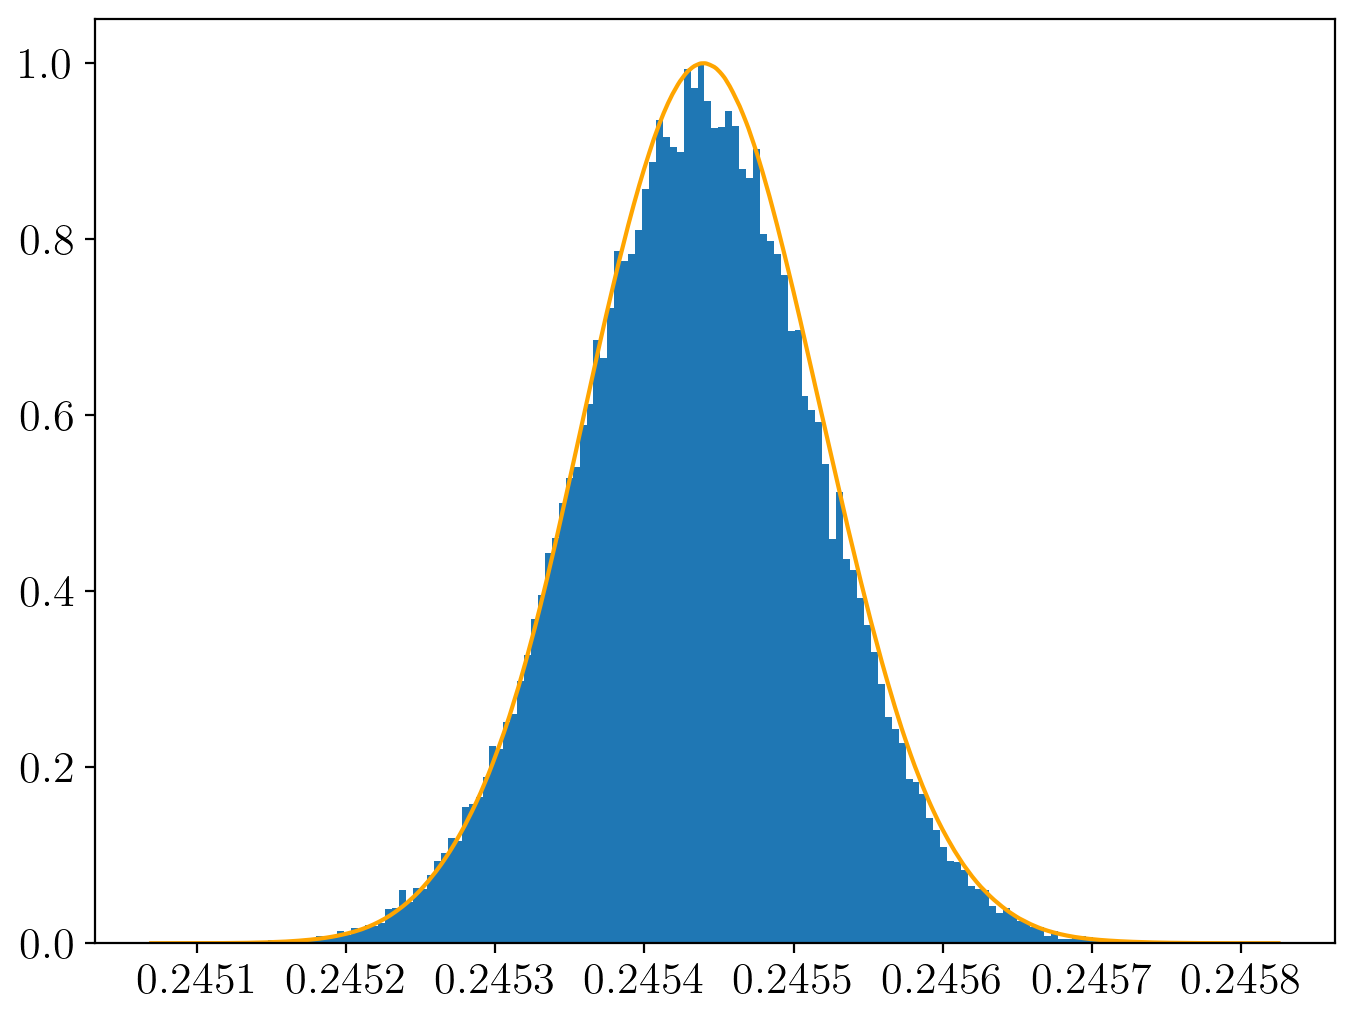

In [34]:
fig,ax = plt.subplots()
param = "YHe"
dens = chains[chain_name].get1DDensity(param)
try:
    bin_height,bin_boundary = np.histogram(total_predictions[param],bins='fd')
except:
    bin_height,bin_boundary = np.histogram(total_models[param],bins='fd')

width = bin_boundary[1]-bin_boundary[0]
bin_height = bin_height/float(max(bin_height))
ax.bar(bin_boundary[:-1],bin_height,width = width)
ax.plot(dens.x, dens.P, color="orange")

In [6]:
chains[chain_name].getParams().rs_d

array([147.95951889, 147.94282366, 145.88026468, ..., 144.797419  ,
       145.00993419, 145.07778022])

In [41]:
chain_as_dict = chains[chain_name].getParams().__dict__
param_dict={}
for p in em.output_info["input_names"]:
        if p=='ln10^{10}A_s':
            param_dict[p]=chain_as_dict["logA"]
        elif p.startswith("q_"):
            if p in chain_as_dict.keys():
                print(p)
                param_dict[p]=chain_as_dict[name]
            else:
                param_dict[p]=np.zeros(len(chains[chain_name].getParams().H0))
        else:
            name = chains[chain_name].getParamNames().parWithName(p).name
            param_dict[p]=chain_as_dict[name]
print(param_dict)

q_1
q_2
q_3
q_4
q_5
{'omega_b': array([0.02256486, 0.0225444 , 0.02254462, ..., 0.02236365, 0.02248937,
       0.02247654]), 'omega_cdm': array([0.12249138, 0.1218157 , 0.12176378, ..., 0.12322145, 0.12241467,
       0.12226622]), 'n_s': array([0.96871316, 0.96779452, 0.96734564, ..., 0.9506615 , 0.95305782,
       0.95285865]), 'tau_reio': array([0.04236216, 0.04340352, 0.04301078, ..., 0.04897628, 0.04780204,
       0.04798959]), 'ln10^{10}A_s': array([3.0326409, 3.0306533, 3.0296797, ..., 3.0364036, 3.0362385,
       3.0365365]), 'H0': array([70.751847, 70.751847, 70.751847, ..., 70.459838, 70.459838,
       70.459838]), 'q_1': array([70.751847, 70.751847, 70.751847, ..., 70.459838, 70.459838,
       70.459838]), 'q_2': array([70.751847, 70.751847, 70.751847, ..., 70.459838, 70.459838,
       70.459838]), 'q_3': array([70.751847, 70.751847, 70.751847, ..., 70.459838, 70.459838,
       70.459838]), 'q_4': array([70.751847, 70.751847, 70.751847, ..., 70.459838, 70.459838,
       70.45